In [1]:
from google.colab import drive

# Mount Google Drive to /content/drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

# Specify the path to your Google Drive project folder
drive_path = "/content/drive/My Drive/Project/ECGFM-KED-main"

# Change Colab’s working directory to the Google Drive folder
os.chdir(drive_path)

# Check the current working directory
print("Current working directory:", os.getcwd())

Current working directory: /content/drive/My Drive/Project/ECGFM-KED-main


In [3]:
# Step 1: Pin the fsspec version required by Colab
!pip install fsspec==2025.3.0 --upgrade --force-reinstall

# Step 2: Install the remaining packages (remove or pin versions that may cause conflicts)
!pip install fastai==1.0.61 torch pandas==2.2.2 scikit-learn tensorboardX \
  matplotlib opencv-python scikit-image tqdm einops torchvision Pillow seaborn timm \
  openpyxl aiohttp requests nltk rouge wfdb

!pip install evaluate --no-deps
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 17.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of wfdb to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.2/239.2 kB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 18.8 MB/s eta 0:00:00
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19172 sha256=254dbeae6429846b2711f07411d0563390978fb51ae3b96e7534ebd02a1f655b
  Stored in directory: /root/.cache/pip/wheels/6e/65/79/33dee66cba26e8204801916dfee7481bccfd22905ebb841fe5
Successfully built nvidia-ml-py3
  Attempting uninstall: fasta

In [4]:
!pip install pyyaml
!pip install utils

  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0.2-py2.py3-none-any.whl size=13906 sha256=0435ad26312e9831ad4879c34b77b3dcf476582671f5b6379cffe28826145014
  Stored in directory: /root/.cache/pip/wheels/b6/a1/81/1036477786ae0e17b522f6f5a838f9bc4288d1016fc5d0e1ec
Successfully built utils


In [5]:
# Define AttrDict directly in the notebook instead of using utils.AttrDict
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.__dict__ = self

In [6]:
import gc
import ast
import os
import argparse # import the argparse module

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

In [ ]:
# Environment setup and initialization
import os
import json
import time
import datetime
import random
import numpy as np
import pandas as pd
import torch
import torch.backends.cudnn as cudnn
import gc

from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from tensorboardX import SummaryWriter

from models.clip_model import CLP_clinical, TQNModel, ModelDense
from models.ECGNet import ECGNet
from models.resnet1d_wang import resnet1d_wang
from models.xresnet1d_101 import xresnet1d101
from models.cpc import CPCModel
from dataset.ecgDataset import MimicivDataset
from optim import create_optimizer
from scheduler import create_scheduler
from engine.train_fg import train, valid_on_ptb
import utils

In [ ]:
# Check and initialize GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.empty_cache()
gc.collect()
print("Total CUDA devices:", torch.cuda.device_count())

# Suppress warnings
torch.set_default_dtype(torch.float32)  # <- replaced with this

# Set random seed
seed = 42  # removed get_rank()
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
cudnn.benchmark = True


Total CUDA devices: 1


In [ ]:
# Load configuration
import yaml
with open("configs/Res_train.yaml", 'r') as f:
    config = yaml.safe_load(f)

In [ ]:
# Model initialization
if config["ecg_model_name"] == 'xresnet1d_101':
    ecg_model = xresnet1d101(num_classes=config["class_num"], input_channels=12, kernel_size=5, ps_head=0.5).to(device)

text_encoder = CLP_clinical(bert_model_name=config["bert_model_name"], freeze_layers=config['freeze_layers']).to(device)
tokenizer = AutoTokenizer.from_pretrained(config["bert_model_name"], do_lower_case=True)

model = TQNModel(num_layers=config["tqn_model_layers"]).to(device)

emilyalsentzer/Bio_ClinicalBERT


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Text feature extractor: emilyalsentzer/Bio_ClinicalBERT
bert encoder layers: 12


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

In [ ]:
checkpoint = torch.load("checkpoints/best_valid_all_increase_with_augment_epoch_3.pt", map_location='cuda')
print(checkpoint.keys())


dict_keys(['model', 'ecg_model', 'text_encoder', 'optimizer', 'lr_scheduler', 'config', 'epoch'])


In [ ]:
# # Load model parameters
# checkpoint = torch.load("checkpoints/ked_latest.pt", map_location='cuda')
# model.load_state_dict(checkpoint['model_state_dict'])
# ecg_model.load_state_dict(checkpoint['ecg_model_state_dict'])
# text_encoder.load_state_dict(checkpoint['text_encoder_state_dict'])

# Use the publicly released pretrained model
# Download from: https://zenodo.org/records/14881564
checkpoint = torch.load("checkpoints/best_valid_all_increase_with_augment_epoch_3.pt", map_location='cuda')
model.load_state_dict(checkpoint['model'])
ecg_model.load_state_dict(checkpoint['ecg_model'])
text_encoder.load_state_dict(checkpoint['text_encoder'], strict=False)

model.eval()
ecg_model.eval()
text_encoder.eval()


CLP_clinical(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
def run_inference(sample, model, ecg_model, text_encoder, tokenizer, device, label_texts, max_length=256):
    signal = sample['signal'].unsqueeze(0).to(device)  # (1, 12, 5000)
    report = [sample['report']]
    label = sample['label']  # optional

    with torch.no_grad():
        ecg_feat, ecg_feat_pool = ecg_model(signal)
        report_feat = get_text_features(text_encoder, report, tokenizer, device, max_length)
        label_feat = get_text_features(text_encoder, label_texts, tokenizer, device, max_length)

        output = model(ecg_feat.transpose(1, 2), label_feat)  # (1, N, 2)
        prob = torch.softmax(output, dim=-1)[..., 1]  # probability for the positive class

        pred = (prob > 0.5).squeeze().cpu().numpy()
        prob = prob.squeeze().cpu().numpy()

    return prob, pred


In [ ]:
from dataset.ecgDataset import MimicivDataset

# Load test data
X_test = pd.read_json("dataset/mimiciv/data_y_total_test.json")
y_test = np.load("dataset/mimiciv/y_test_one_hot_data.npy", allow_pickle=True)

# Create the test dataset (set the label type according to the configuration)
test_dataset = MimicivDataset(X_test, y_test, use_what_label="mimiciv_label")


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MultiLabelBinarizer from version 1.3.0 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [7]:
# Specify the path to your Google Drive project folder
drive_path = "/content/drive/My Drive/Project"

# Change Colab’s working directory to the Google Drive folder
os.chdir(drive_path)

# Check the current working directory
print("Current working directory:", os.getcwd())


Current working directory: /content/drive/My Drive/Project


In [ ]:
import pickle
with open("ECGFM-KED-main/dataset/mimiciv/mlb.pkl", "rb") as f:
    mlb = pickle.load(f)

text_list = mlb.classes_.tolist()


In [ ]:
def run_inference(sample, model, ecg_model, text_encoder, tokenizer, device, label_texts, max_length=256):
    signal = sample['signal'].unsqueeze(0).to(device).float()
    report = [sample['report']]
    label = sample['label']

    with torch.no_grad():
        try:
            ecg_feat, ecg_feat_pool = ecg_model(signal)  # Standard model structure
        except:
            ecg_feat = ecg_model(signal)                 # Alternate structure (e.g., resnet1d)
            ecg_feat_pool = ecg_feat.mean(-1)

        report_feat = get_text_features(text_encoder, report, tokenizer, device, max_length)
        label_feat = get_text_features(text_encoder, label_texts, tokenizer, device, max_length)

        output = model(ecg_feat.transpose(1, 2), label_feat)
        prob = torch.softmax(output, dim=-1)[..., 1]

        pred = (prob > 0.3).squeeze().cpu().numpy()
        prob = prob.squeeze().cpu().numpy()

    return prob, pred


def get_text_features(model, text_list, tokenizer, device, max_length):
    text_token = tokenizer(
        list(text_list),
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding="max_length",
        return_tensors='pt'
    ).to(device=device)

    text_features = model.encode_text(text_token)
    return text_features


In [ ]:
# Example: Load one sample from the test set
sample = test_dataset[18]
label_texts = text_list  # Must match the same text_list used during training
probs, preds = run_inference(sample, model, ecg_model, text_encoder, tokenizer, device, text_list)

print("\n🔍 Prediction results:")
for label, p, y in zip(label_texts, probs, preds):
    mark = "*" if y else "✖️"
    print(f"{label:40} | prob = {p:.3f} → {mark}")



🔍 예측 결과:
QRS changes in V3/V4 leads               | prob = 0.000 → ✖️
ST segment elevation                     | prob = 0.000 → ✖️
T wave abnormality                       | prob = 0.000 → ✖️
aberrant ventricular conduction          | prob = 0.000 → ✖️
abnormal ECG                             | prob = 0.106 → ✖️
abnormal R wave progression              | prob = 0.000 → ✖️
accelerated idioventricular rhythm       | prob = 0.000 → ✖️
accelerated junctional rhythm            | prob = 0.000 → ✖️
acute ST segment elevation myocardial infarction | prob = 0.000 → ✖️
acute myocardial infarction              | prob = 0.000 → ✖️
anterior myocardial infarction           | prob = 0.000 → ✖️
anterior/septal and lateral ST-T changes | prob = 0.000 → ✖️
anterolateral ST-T changes               | prob = 0.000 → ✖️
anterolateral T wave changes             | prob = 0.000 → ✖️
anterolateral myocardial infarction      | prob = 0.000 → ✖️
anteroseptal myocardial infarction       | prob = 0.000 → ✖️
atrial

In [ ]:
# inside CLP_clinical class
def encode_texts(self, texts):
    tokenized = self.tokenizer(texts, padding=True, truncation=True,
                               max_length=128, return_tensors="pt").to(self.bert.device)
    outputs = self.bert(**tokenized)
    return outputs.pooler_output  # or mean pooling


In [ ]:
def plot_ecg_with_attention_full(ecg_signal, attention, title="ECG with Attention", label=None):
    import matplotlib.pyplot as plt
    import numpy as np

    # Total ECG length
    full_len = len(ecg_signal)

    # Attention length (e.g., 32)
    att_len = len(attention)
    step = full_len // att_len

    # Normalize attention
    attention = (attention - np.min(attention)) / (np.max(attention) - np.min(attention) + 1e-8)

    fig, ax = plt.subplots(figsize=(14, 3))
    ax.plot(ecg_signal, label="ECG Signal")

    for i in range(att_len):
        start = i * step
        end = min((i + 1) * step, full_len)
        alpha = attention[i] * 0.5
        ax.axvspan(start, end, color='red', alpha=alpha)

    ax.set_title(title if not label else f"{title} - Label: {label}")
    ax.set_xlabel("Time (samples)")
    ax.set_ylabel("Amplitude")
    ax.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
def plot_ecg_12leads_with_attention(ecg_signal_12lead, attention, label):
    """
    ecg_signal_12lead: shape (12, T) — 12-lead ECG waveform
    attention: shape (32,) — attention weights for 32 segments
    label: str — label name
    """
    import matplotlib.pyplot as plt
    import numpy as np

    full_len = ecg_signal_12lead.shape[1]
    att_len = len(attention)
    step = full_len // att_len
    attention = (attention - np.min(attention)) / (np.max(attention) - np.min(attention) + 1e-8)

    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    fig, axes = plt.subplots(6, 2, figsize=(14, 10), sharex=True)
    axes = axes.flatten()

    for lead_idx in range(12):
        sig = ecg_signal_12lead[lead_idx]
        ax = axes[lead_idx]
        ax.plot(sig, label=lead_names[lead_idx], linewidth=1)

        for i in range(att_len):
            start = i * step
            end = min((i + 1) * step, full_len)
            ax.axvspan(start, end, color='red', alpha=attention[i] * 0.4)

        ax.set_ylabel("mV")
        ax.set_title(lead_names[lead_idx])
        ax.grid(True)

    fig.suptitle(f"Attention Map for: {label}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()


In [ ]:
# Select one ECG sample
ecg_example = test_dataset[40]['signal']  # 40

# Prepare the ECG signal
ecg_tensor = ecg_example.unsqueeze(0).float().to(device)  # [1, 12, 1000]

# Pass through the ECG encoder
with torch.no_grad():
    ecg_features = ecg_model(ecg_tensor)  # [1, 768, 32]
    ecg_features = ecg_features.permute(0, 2, 1).contiguous()  # → [1, 32, 768]

# Compute text embeddings
tokenized = tokenizer(label_texts, padding=True, truncation=True, max_length=128, return_tensors="pt")
tokenized = {k: v.to(device) for k, v in tokenized.items()}
text_features = text_encoder.encode_text(tokenized)  # [num_labels, 768]

# Model prediction and attention extraction
with torch.no_grad():
    logits, attention = model(ecg_features, text_features, return_atten=True)
    attention = attention.squeeze().cpu().numpy()


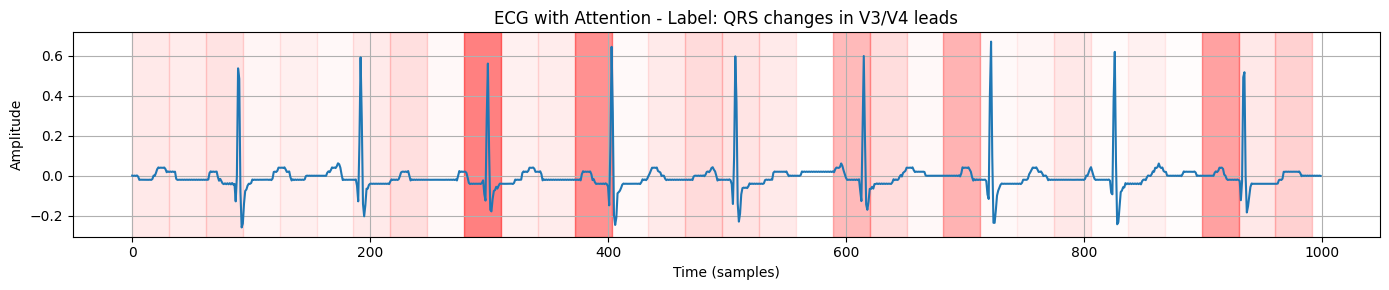

In [ ]:
lead_idx = 0
label_text_idx = 0

plot_ecg_with_attention_full(
    ecg_signal=ecg_example[lead_idx].cpu().numpy(),  # Entire first lead among the 12-lead signals
    attention=attention[label_text_idx],             # Attention corresponding to label 0
    label=label_texts[label_text_idx]
)


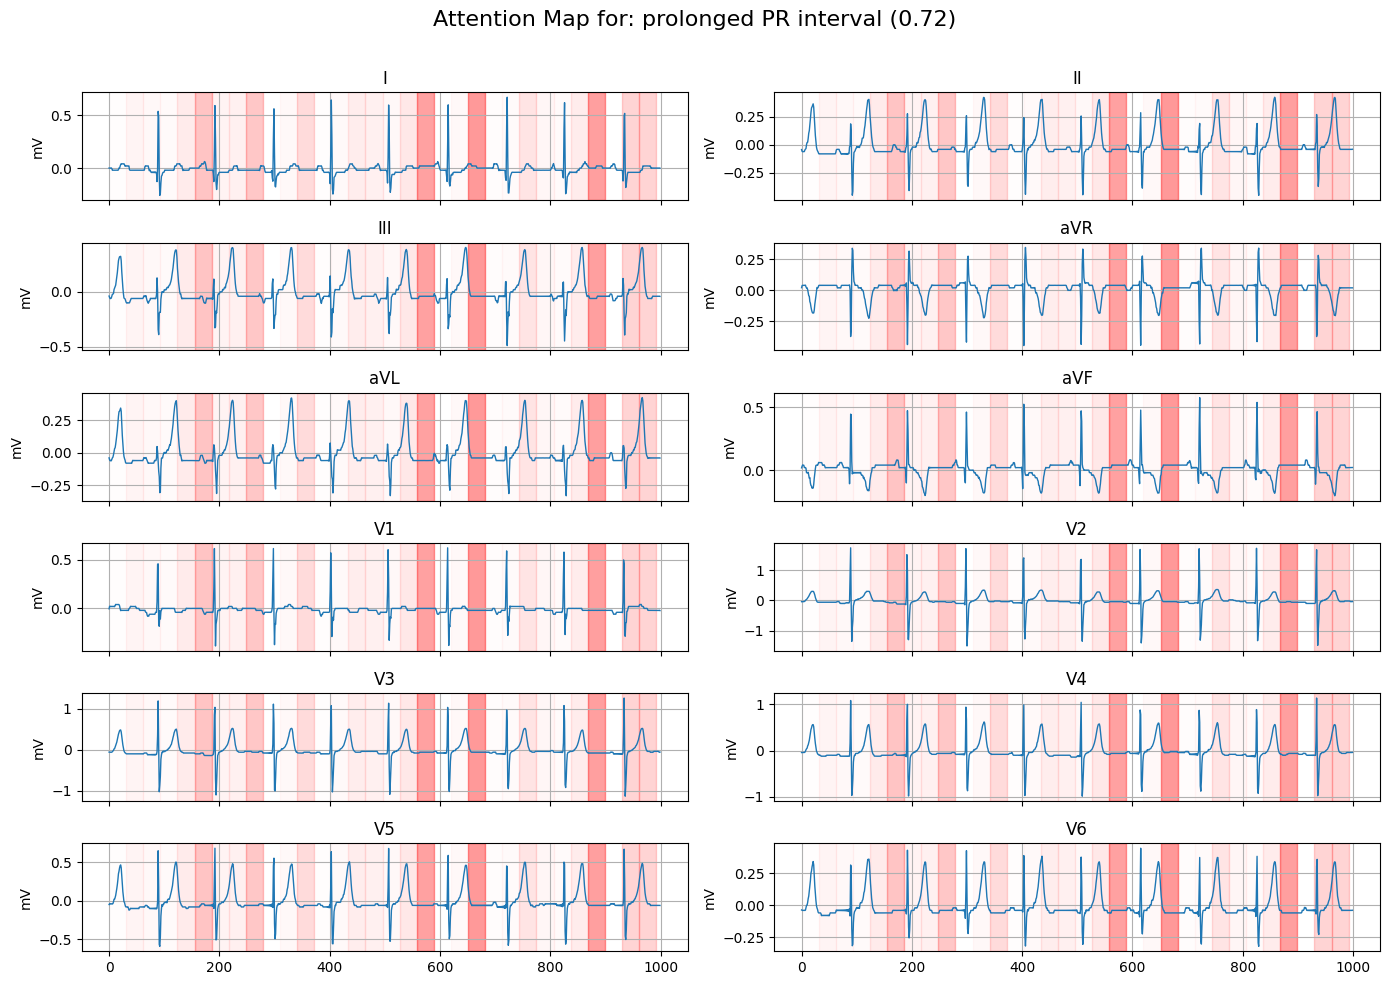

In [ ]:
# Calculate probabilities
probs = torch.sigmoid(logits)
if probs.ndim == 3:
    probs = probs[:, :, 1]
probs = probs.squeeze().cpu().numpy()

# Select the label with the highest probability
top_idx = probs.argmax()

# Visualize attention across all 12 leads
plot_ecg_12leads_with_attention(
    ecg_signal_12lead=ecg_example.cpu().numpy(),  # shape: [12, T]
    attention=attention[top_idx],                 # shape: [32]
    label=f"{label_texts[top_idx]} ({probs[top_idx]:.2f})"
)


In [ ]:
top_label_idx = probs.argmax()

import torch.nn.functional as F

# ECG feature shape: [1, 32, 768] → squeeze
ecg_seq = ecg_features.squeeze(0)  # [32, 768]
attn_vec = attention[top_label_idx]  # shape: [32]
attn_tensor = torch.tensor(attn_vec, dtype=torch.float32).to(ecg_seq.device)

# attention-weighted ECG vector (ECG representation)
vec_ecg = torch.sum(ecg_seq * attn_tensor.unsqueeze(1), dim=0)  # [768]
vec_ecg = F.normalize(vec_ecg, dim=0)


In [ ]:
# Normalize diagnostic text embeddings
text_feats_norm = F.normalize(text_features, dim=1)  # [num_labels, 768]

# Compute cosine similarity between the ECG attention-weighted vector and each diagnostic vector
sims = F.cosine_similarity(vec_ecg.unsqueeze(0), text_feats_norm)  # [num_labels]

# Convert to NumPy (after detaching from the computation graph)
sims = sims.detach().cpu().numpy()


In [ ]:
top_k = 5
nearest_idx = sims.argsort()[::-1][:top_k]

print("Diagnoses the model found most relevant based on attention:")
for idx in nearest_idx:
    print(f" *{label_texts[idx]}: similarity = {sims[idx]:.3f}")


모델이 attention 기반으로 가장 의미 있다고 판단한 진단들:
 *first degree atrioventricular block: similarity = 0.040
 *prolonged PR interval: similarity = 0.029
 *hypertrophy: similarity = 0.027
 *sinus bradycardia: similarity = 0.016
 *ST segment elevation: similarity = 0.014
